In [28]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import lmfit as fitter
import ETFunctions as et
from datetime import datetime
import matplotlib.dates as mdates
import GraphHelpers as GH

## Bring in data

In [29]:
DailyTempDiff = pd.read_pickle('.\DataFrames/DayTimeMeanSurfaceTemp.pkl')
DailyTempDiff.sort_index(axis=1,inplace=True)
HourlyWateruse = pd.read_pickle('.\DataFrames/HourlyWUmm.pkl')
HourlyWateruse.sort_index(axis=1,inplace=True)
TnRData = pd.read_pickle('.\DataFrames/TempAndMet.pkl')
TnRData.sort_index(axis=1,inplace=True)
SHFData = pd.read_pickle('.\DataFrames/HourlySoilHeatFluxTotalMJ.pkl')
SHFData.sort_index(axis=0,inplace=True)
RnDF = pd.read_pickle('.\DataFrames/NetRadiationMJ.pkl')
RnDF.sort_index(axis=0,inplace=True)

#Bring in estimated upper and lower canopy temp limits
#HourlyTsBounds = pd.read_pickle('.\DataFrames\TsTaULDF.pkl')
#HourlyTsBounds.index.name = 'Date'
#the earliest common time
ECT = '2015-10-16 00:00:00'
#the latest common time
LCT = '2016-02-15 00:00:00'

Albedo = 0.23
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28
Cp = 1013 #Heat capacity of air Joule/kg/oC
D0 = 4000#1200
D6 = 2000
DB = 4
E = -0.0005
C1 = 1.2
C0 = 2.0
CB = 0.6
##Contract dataframes down to common index size
HourlyWateruse = HourlyWateruse.loc[ECT:LCT,:]
TnRData = TnRData.loc[ECT:LCT,:]
TnRData.index.name='Date'

In [30]:
GPs = GH.SetGraphicsPatterns(TnRData.BelowCanopyPAR.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '250', '50']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '250', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Dryland   0     -  orange  0.15   o  orange
          250   -   green  0.15   o   green
          50    -  purple  0.15   o  purple
Irrigated 0    --  orange  0.45   ^   white
          250  --   green  0.45   ^   white
          50   --  purple  0.45   ^   white


# Clean up all the crap

In [21]:
# #Create a list of time to exclude where irrigation applications caused noise
# IrrigationDates = pd.to_datetime(['2014-11-11','2014-11-18','2014-11-26','2014-12-02','2014-12-10','2014-12-16',
#                     '2014-12-23','2014-12-30','2015-01-06','2015-01-13','2015-01-14'])
# #Remove data from daily dataframes
# #DailyWaterUse = DailyWaterUse.loc[~DailyWaterUse.index.isin(IrrigationDates)]
# DailyTempDiff = DailyTempDiff.loc[~DailyTempDiff.index.isin(IrrigationDates)]
# #Make hourly exclusion index and remove data from hourly data frames
# IrrigationDateTimes = []
# for irrigDate in IrrigationDates:
#     IrrigationDateTimes += pd.date_range(irrigDate,periods=24,freq='H')
# HourlyWateruse = HourlyWateruse.loc[~HourlyWateruse.index.isin(IrrigationDateTimes)]
# #Make 15 min exclusion index and remove data from 15min data frames
# IrrigationDateTimes15 = []
# for irrigDate in IrrigationDates:
#     IrrigationDateTimes15 += pd.date_range(irrigDate,periods=96,freq='15T')
# SHFData = SHFData.loc[~SHFData.index.isin(IrrigationDateTimes15,level=3)]
# #Make 5 min exclusion index and remoe data from 5min data frames
# IrrigationDateTimes5 = []
# for irrigDate in IrrigationDates:
#     IrrigationDateTimes5 += pd.date_range(irrigDate,periods=288,freq='5T')
# TnRData = TnRData.loc[~TnRData.index.isin(IrrigationDateTimes5)]

In [35]:
#NoMeasurementDates = ['2014-12-26','2014-12-27','2014-12-28']
DailyWaterUse = HourlyWateruse.resample('d').sum()
#DailyWaterUse = DailyWaterUse.loc[~DailyWaterUse.index.isin(NoMeasurementDates)]
DailyWaterUse = DailyWaterUse.reindex(DailyTempDiff.index) * -1
DailyWaterUse.sort_index(axis=0,inplace=True)
DailyWaterUse.sort_index(axis=1,inplace=True)
DailyWaterUseMeans = DailyWaterUse.groupby(level = ['Irrigation','Nitrogen'],axis=1).mean()

In [32]:
DailyTempDiff

Irrigation   Dryland                      Irrigated                    
Nitrogen           0       250         50         0       250        50
2015-10-15  4.941974  4.286708   5.353816  4.059642  5.131842  5.450658
2015-10-16  4.371158  4.488283   5.156750  1.176881  2.011048  1.978987
2015-10-17  4.734636  4.447338   4.696476  2.753552  2.806782  2.910312
2015-10-18  5.591810  5.848388   7.182754  1.405579  2.116431  2.017181
2015-10-19  7.135773  7.040170   7.926407  5.245273  5.651051  5.294096
2015-10-20  6.769873  6.884260   7.946407  5.552346  6.093519  5.999113
2015-10-21  3.035783  3.046859   3.673180  1.249107  2.112608  1.836072
2015-10-22  7.273087  7.379026   8.483872  5.381381  6.120280  6.037780
2015-10-23  6.118594  5.638531   6.370462  3.341125  3.451750  3.428250
2015-10-24  6.900321  6.961673   8.016948  4.080357  4.227273  4.315812
2015-10-25  7.000681  6.378860   7.631676  4.427788  4.636073  4.401381
2015-10-26  6.159114  6.073114   7.473729  4.281824  4.421764  4.419641
2015-10-27  6.175581  5.369789   6.218599  4.630324  4.674524  4.740885
2015-10-28  3.410031  3.122805   3.374815  2.633001  2.721420  2.674401
2015-10-29  4.286158  3.707104   3.923461  3.293448  3.314078  3.405566
2015-10-30  7.702545  5.514355   5.854107  4.760340  4.699207  4.867071
2015-10-31  7.745460  4.901107   5.143802  4.147556  4.081994  4.130639
2015-11-01  7.290551  5.064016   6.681373  3.524482  3.174655  3.368713
2015-11-02  2.581387  4.286630   5.540552  1.643640  1.694866  1.992546
2015-11-03  1.186586  1.286864   1.293310  0.513963  0.489457  0.702049
2015-11-04  4.742924  4.262753   4.923372  3.839273  3.737226  3.931960
2015-11-05  6.124944  5.872863   7.628832  4.115425  4.300784  4.746405
2015-11-06  6.027499  5.632631   6.986384  3.468948  3.300229  3.623372
2015-11-07  6.817278  5.500739   8.022596  4.294747  4.166596  4.431416
2015-11-08  4.591177  3.569276   4.513219  2.337719  1.921719  2.430215
2015-11-09  7.225526  5.952678   8.385602  4.353842  4.066054  4.624217
2015-11-10  7.523619  6.351218   7.973415  3.966997  3.191951  3.920610
2015-11-11  4.092100  3.060333   3.892533  2.312900  1.992500  2.369767
2015-11-12  5.879964  4.677234   5.388876  3.922425  3.215464  4.092136
2015-11-13  7.990664  6.699982   9.219056  4.256448  3.136344  4.177670
...              ...       ...        ...       ...       ...       ...
2016-01-18  5.910000  4.831888   5.473434  4.236898  3.354521  3.981024
2016-01-19  6.356599  5.054706   5.764797  3.974839  2.484900  3.532994
2016-01-20  9.886798  9.045659  10.202151  5.896535  1.903910  4.123256
2016-01-21  8.497588  7.110196   8.257647  3.584846 -1.672403  1.150471
2016-01-22  8.808069  8.064431   9.452971  4.589764 -1.632818  1.676235
2016-01-23  6.136722  5.090363   5.845465  2.433539 -2.847172 -0.037703
2016-01-24  1.707284  1.493992   1.633704  0.151821 -1.639540 -0.641605
2016-01-25  2.854968  2.219103   2.550224  0.625160 -1.896787 -0.439487
2016-01-26  4.077813  3.448917   3.879958  3.387469  2.111875  2.987000
2016-01-27  6.572500  5.227960   6.077785  5.273140  3.868402  4.889715
2016-01-28  7.654979  6.078155   7.036488  5.709655  3.308133  4.842976
2016-01-29  9.167496  7.801804   9.283794  7.175239  2.881331  5.505500
2016-01-30  7.928796  6.638477   7.847778  6.064722  2.444141  4.716821
2016-01-31  9.067064  8.076776   9.441159  6.626453  2.886674  5.307340
2016-02-01  8.874793  8.484701   9.652113  6.522158  3.023192  5.157594
2016-02-02  9.361612  8.648651  10.140506  7.047383  2.824861  5.088564
2016-02-03  5.187493  5.204921   5.230149  6.666324  3.549136  5.579392
2016-02-04  1.451616  2.070610   1.581982  5.145932  1.650486  3.375143
2016-02-05  3.972656  3.657917   3.771281  5.520531  2.821545  4.371969
2016-02-06  4.084905  3.804219   3.922880  5.595057  3.180576  4.519771
2016-02-07  3.421944  3.546173   3.652994  4.927444  2.997092  4.037438
2016-02-08  4.300586  4.386379   4.544198  5.967342  3.522784  4.967747
2016-02-09  4.079873  3.671646   3.90316

In [36]:
DailyWaterUseMeans

Irrigation   Dryland                     Irrigated                    
Nitrogen           0       250        50         0       250        50
2015-10-15       NaN       NaN       NaN       NaN       NaN       NaN
2015-10-16  0.549375  0.639375  0.510000  0.753750 -0.001875 -0.210000
2015-10-17  0.746250  0.641250  0.558750  1.543125  0.003750  0.146250
2015-10-18  1.188750  1.070625  0.826875  2.323125  1.237500  1.505625
2015-10-19  1.233750  0.916875  0.862500  1.537500  0.991875  1.153125
2015-10-20  1.415625  1.205625  0.999375  1.513125  1.299375  1.376250
2015-10-21  1.447500  1.256250  1.072500  1.680000  1.535625  1.466250
2015-10-22  1.209375  1.194375  0.960000  0.570000 -0.406875 -0.337500
2015-10-23  0.960000  1.018125  0.804375  1.438125  0.133125  0.114375
2015-10-24  1.312500  1.310625  1.029375  1.944375  1.321875  1.263750
2015-10-25  1.280625  1.258125  1.005000  1.569375  1.213125  1.323750
2015-10-26  1.535625  1.546875  1.025625  1.966875  1.824375  1.687500
2015-10-27  1.111875  0.990000  0.849375  1.057500  1.111875  1.031250
2015-10-28  0.714375  0.804375  0.579375  0.774375  0.796875  0.729375
2015-10-29  0.811875  0.877500  0.631875 -0.873750 -1.156875 -2.261250
2015-10-30  1.537500  1.953750  2.375625  2.409375 -0.915000 -0.920625
2015-10-31  1.456875  1.706250  1.368750  3.663750  2.150625  1.685625
2015-11-01  1.500000  1.507500  1.173750  3.785625  3.474375  2.896875
2015-11-02  4.944375  1.951875  2.006250  3.180000  3.210000  2.512500
2015-11-03  2.040000  1.590000  1.741875  2.630625  2.197500  1.753125
2015-11-04  1.372500  1.545000  1.190625  2.420625  2.471250  1.936875
2015-11-05  1.507500  1.901250  1.323750  3.303750  3.727500  2.936250
2015-11-06  1.438125  1.893750  1.290000  2.791875  2.370000  2.143125
2015-11-07  1.125000  1.749375  1.158750  2.773125  2.435625  2.094375
2015-11-08  1.005000  1.421250  1.061250  2.111250  1.938750  1.565625
2015-11-09  1.400625  2.090625  1.393125  3.286875  3.485625  2.688750
2015-11-10  1.524375  2.280000  1.533750  3.695625  4.158750  3.058125
2015-11-11  1.038750  1.552500  1.186875  2.186250  2.437500  1.903125
2015-11-12  1.046250  1.644375  1.254375  1.087500  0.536250  0.532500
2015-11-13  1.567500  2.608125  1.580625  3.003750  3.283125  2.673750
...              ...       ...       ...       ...       ...       ...
2016-01-18  0.298125 -0.039375  0.307500  1.065000  1.036875  0.376875
2016-01-19  0.112500 -0.026250  0.054375  1.261875  1.807500  0.894375
2016-01-20 -0.558750 -0.630000 -0.457500  2.206875  5.431875  2.745000
2016-01-21 -0.504375 -0.716250 -0.450000  2.823750  4.241250  3.571875
2016-01-22 -0.733125 -0.800625 -0.691875  2.675625  7.481250  3.941250
2016-01-23 -0.440625 -0.789375 -0.515625  2.131875  5.806875  3.076875
2016-01-24  0.033750 -0.296250 -0.135000  1.361250  2.896875  1.833750
2016-01-25  0.016875 -0.268125 -0.123750  1.265625  3.123750  1.805625
2016-01-26  0.395625  0.211875  0.196875  0.862500  1.078125  0.990000
2016-01-27  0.474375  0.322500  0.408750  0.905625  1.016250  1.014375
2016-01-28  0.136875  0.071250  0.114375  0.860625  1.914375  1.068750
2016-01-29 -0.174375 -0.165000 -0.210000  0.971250  2.452500  1.376250
2016-01-30  0.003750 -0.136875 -0.099375  0.819375  2.075625  1.246875
2016-01-31 -0.245625 -0.328125 -0.198750  0.898125  2.433750  1.260000
2016-02-01 -0.433125 -0.585000 -0.515625  0.868125  2.116875  1.181250
2016-02-02 -0.738750 -0.853125 -0.750000  0.742500  2.156250  1.100625
2016-02-03  1.213125 -1.119375  1.188750  0.538125  1.393125  0.868125
2016-02-04  4.856250 -2.681250  4.042500  0.896250  2.347500  1.104375
2016-02-05  1.284375  0.005625  1.685625  0.746250  0.991875  0.916875
2016-02-06  1.286250  1.003125  1.689375  0.780000  1.149375  0.960000
2016-02-07  1.248750  1.042500  1.246875  0.811875  1.151250  1.063125
2016-02-08  1.218750  0.879375  1.269375  0.703125  1.100625  0.770625
2016-02-09  1.166250  1.023750  1.170000  0.802500  1.012500  0.993750
2016-02-10  1.376250  1.

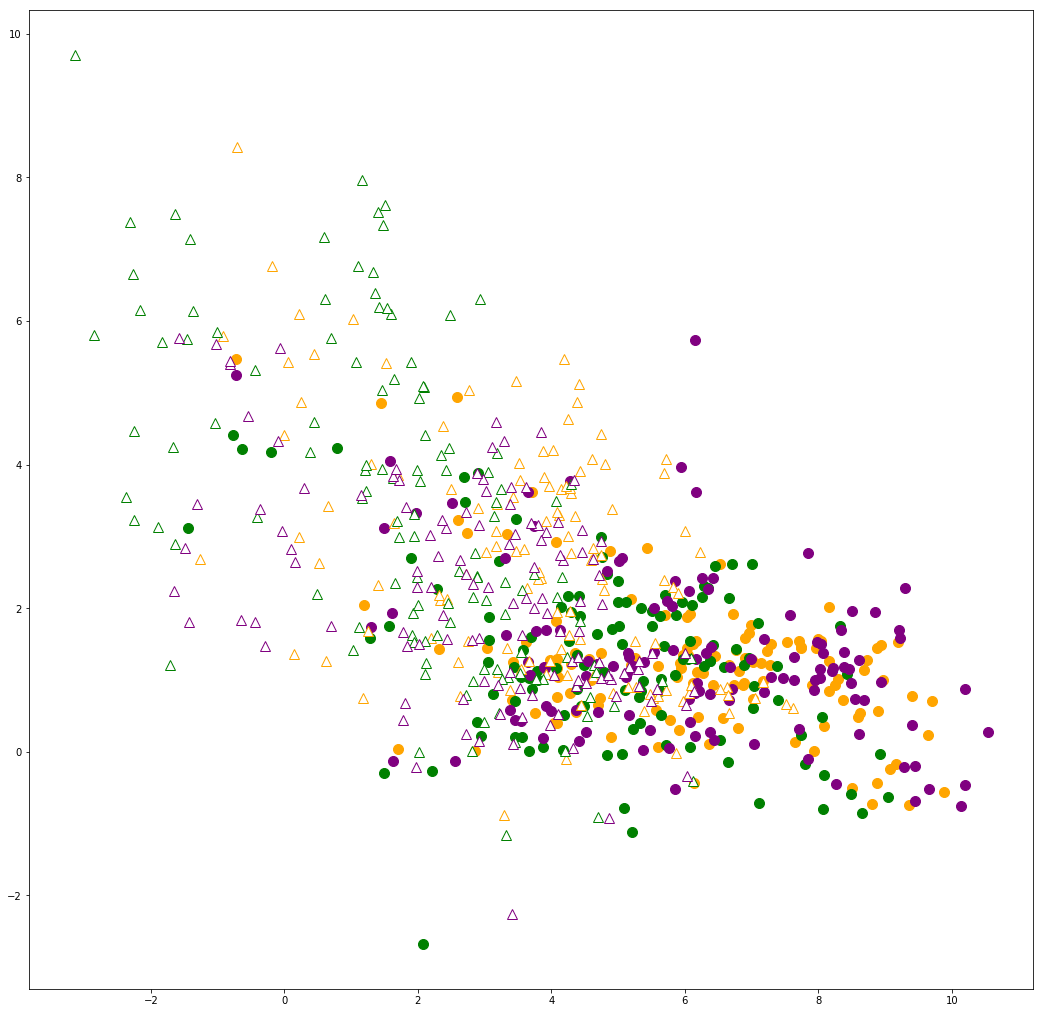

In [38]:
Graph = plt.figure(figsize = (18,18))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedXY(DailyTempDiff,DailyWaterUseMeans,ax,GPs,10)

## Make a data frame with hourly mean energy balance data in W/m2

### Bring in the cover Data

In [39]:
CoverData = pd.read_pickle('.\DataFrames\DailyFPAREstInt.pkl')
CoverData.sort_index(axis=1,inplace=True)
CoverData.groupby(level=['Irrigation','Nitrogen'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

FileNotFoundError: [Errno 2] No such file or directory: '.\\DataFrames\\DailyFPAREstInt.pkl'

Text(0,0.5,'Cover Green')

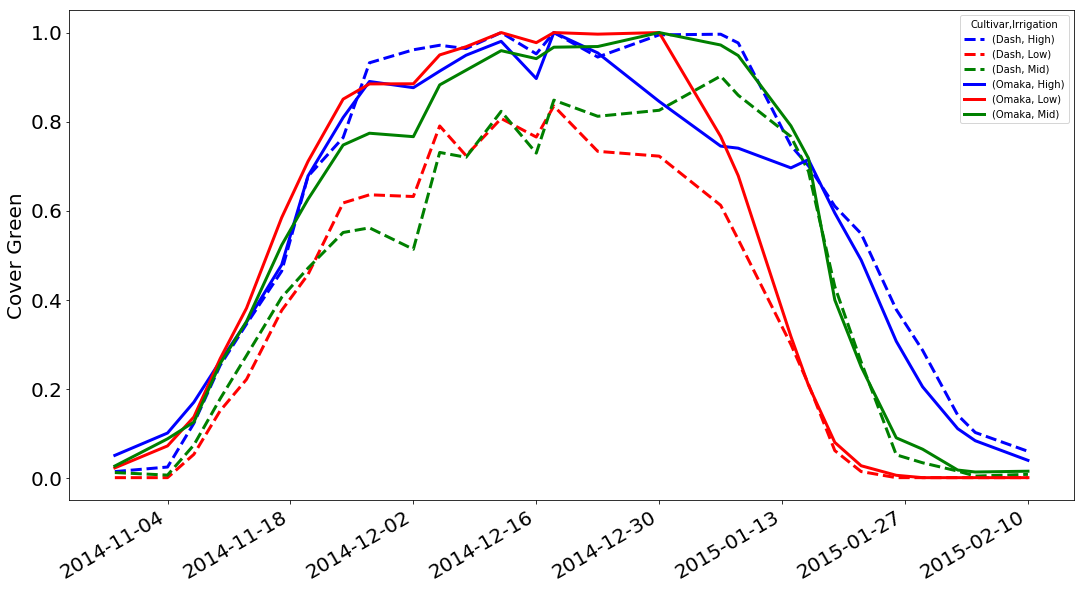

In [35]:
GreenCoverData = pd.read_pickle('.\DataFrames\FPARGreenEstimated.pkl')
GreenCoverData.sort_index(axis=1,inplace=True)
GreenCoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

In [36]:
def makeSeries(Var,Frame):
    SSeries= Frame.loc[Var]
    SSeries.name = Var
    SSeries.index = SSeries.index.droplevel()
    SSeries.index = SSeries.index.droplevel()
    return SSeries

In [37]:
import math as math #import library for math functions
def RaZot(WindSpeed, Zu, h, Zot_Zom):
    """Aerodynamic resistance based on wind speed as described by Maes and Stepp 2012 in sm-1
    
    Original Reference: Thom and Oliver, 1977.  On Penmans equation for estimating regaional evaporation.  J Q R Meteorological Soc 98: 124
    
    Args:
        WindSpeed in m/s
        Zu in m is the hight that wind speed and temperature are measured 
        and is 1.2 m for a standard met station
        h in m is the height of the canopy 
    """
    if WindSpeed < 1.0:
        WindSpeed = 1
    d = (0.63*h)  # is the zero displacement height which is a complex function of canopy height and archicture
    Zot = (0.13*h) * Zot_Zom # is the roughness length of temperature and is also influenced by canopy height and archicture
    LN = math.log((Zu-d)/Zot)
    _ret = math.pow(LN,2)/(0.16*WindSpeed)
    return _ret 

In [50]:
#Start off data frame with net radiation data W/m2
#need to make this measured Rn not estimated
RnDF.name = 'Rn'
EnergyBalance = pd.DataFrame(RnDF)
#SoilHeatFlux Data is in W/m2 so join into frame
EnergyBalance = EnergyBalance.join(SHFData)

#Make hourly water use long
HourlyWateruse.index.name = 'Date'
HWULong = HourlyWateruse.unstack()
#Make hourly water use positive
PHWU = HWULong * -1
PHWU.name = 'PHWU'
#join into dataframe
EnergyBalance = EnergyBalance.join(PHWU)

#Get some other variables into dataframe
DateSet = EnergyBalance.loc[('Dash','Low','1'),:].index
TnRDataLong = TnRData.resample('h').mean().loc[DateSet].unstack()
LamdaSeries = makeSeries('lamda',TnRDataLong)
tempSeries = makeSeries('AirTemperature',TnRDataLong)
windSeries = makeSeries('Windspeed',TnRDataLong)
qSeries = makeSeries('q',TnRDataLong)
VPDSeries = makeSeries('VPD',TnRDataLong)

for plot in DetailsPlotsList:
    #Hourly Water use in mm is equal to kg/m2 need to multiply by latent heat of vapourisation to convert to MJ
    LESeries = np.multiply(EnergyBalance.loc[plot,'PHWU'], LamdaSeries)
    EnergyBalance.loc[plot,'HLEMJ'] = LESeries.values
    EnergyBalance.loc[plot,'Ta'] = tempSeries.values
    EnergyBalance.loc[plot,'u'] = windSeries.values
    EnergyBalance.loc[plot,'q'] = qSeries.values
    EnergyBalance.loc[plot,'VPD'] = VPDSeries.values
    EnergyBalance.loc[plot,'lamda'] = LamdaSeries.values

    
#then divide by duration (3600 seconds) to give latent heat in MW and divide by a million to convert to W
EnergyBalance.loc[:,'LE'] = EnergyBalance.loc[:,'HLEMJ']#/3600 * 1000000

#Calculate sensible heat and put into data frame
EnergyBalance.loc[:,'H'] = EnergyBalance.loc[:,'Rn'] - EnergyBalance.loc[:,'G'] - EnergyBalance.loc[:,'LE'] 

#Make the surface temperature data long and join into dataframe
TsDF = TnRData.reindex(index=DateSet)['IR_SurfaceTemp']
TsDF.columns = HourlyWateruse.sort_index(axis=1).columns
TsLong = TsDF.unstack()
TsLong.name= 'Ts'
EnergyBalance = EnergyBalance.join(TsLong)
EnergyBalance.loc[:,'uVPD'] = EnergyBalance.loc[:,'u'] * EnergyBalance.loc[:,'VPD']
EnergyBalance.loc[:,'Ts-Ta'] = EnergyBalance.loc[:,'Ts'] - EnergyBalance.loc[:,'Ta']
EnergyBalance.loc[:,'qCp'] = EnergyBalance.loc[:,'q']*Cp
EnergyBalance.loc[:,'Cover'] = CoverData.loc[DateSet].bfill().unstack()
EnergyBalance.loc[:,'GreenCover'] = GreenCoverData.loc[DateSet].bfill().unstack()
EnergyBalance.loc[:,'Rn-G'] = EnergyBalance.loc[:,'Rn'] - EnergyBalance.loc[:,'G']
EnergyBalance.loc[:,'H/(Rn-G)'] = EnergyBalance.loc[:,'H'] / EnergyBalance.loc[:,'Rn-G']
EnergyBalance.loc[:,'abs(H/(Rn-G))'] = EnergyBalance.loc[:,'H/(Rn-G)'].abs()
EnergyBalance.loc[:,'(Ts-Ta)qCp'] = EnergyBalance.loc[:,'Ts-Ta'] * (EnergyBalance.loc[:,'qCp'])
EnergyBalance.loc[:,'Ra'] =  (EnergyBalance.loc[:,'(Ts-Ta)qCp']*86400)/EnergyBalance.loc[:,'H']
#EnergyBalance.loc[:,'Ra'] = EnergyBalance.loc[:,'Ra'].abs()
EnergyBalance.loc[:,'abs(H/(Rn-G))/Ra'] = EnergyBalance.loc[:,'abs(H/(Rn-G))']/EnergyBalance.loc[:,'Ra']

#Join in estimated upper canopy temp limits
EnergyBalance.loc[:,'TsUL-Ta'] = HourlyTsBounds.resample('h').mean().loc[DateSet].bfill().unstack()

#Calculate some more stuff
#EnergyBalance.loc[:,'(TsLL-Ta)qCp'] = np.multiply(EnergyBalance.loc[:,'TsLL-Ta'] , EnergyBalance.loc[:,'qCp'])
EnergyBalance.loc[:,'maxH/(Rn-G)'] = 1.0 - EnergyBalance.loc[:,'GreenCover']*-0.4 
EnergyBalance.loc[:,'depH/(Rn-G)'] = EnergyBalance.loc[:,'maxH/(Rn-G)'] - EnergyBalance.loc[:,'H/(Rn-G)']
EnergyBalance.loc[:,'(TsUL-Ta)qCp'] = np.multiply(EnergyBalance.loc[:,'TsUL-Ta'] , EnergyBalance.loc[:,'qCp'])
EnergyBalance.loc[:,'TsUL'] = EnergyBalance.loc[:,'Ta'] + EnergyBalance.loc[:,'TsUL-Ta']
EnergyBalance.loc[:,'ToUL'] = EnergyBalance.loc[:,'TsUL'] + EnergyBalance.loc[:,'VPD'] * 1
EnergyBalance.loc[:,'ToUL-Ta'] = EnergyBalance.loc[:,'ToUL'] - EnergyBalance.loc[:,'Ta']
EnergyBalance.loc[:,'(ToUL-Ta)qCp'] = np.multiply(EnergyBalance.loc[:,'ToUL-Ta'] , EnergyBalance.loc[:,'qCp'])

EnergyBalance.loc[:,'To'] = EnergyBalance.loc[:,'Ts'] + EnergyBalance.loc[:,'VPD'] * 1
EnergyBalance.loc[:,'To-Ta'] = EnergyBalance.loc[:,'To'] - EnergyBalance.loc[:,'Ta']
EnergyBalance.loc[:,'(To-Ta)qCp'] = EnergyBalance.loc[:,'To-Ta'] * EnergyBalance.loc[:,'qCp']
EnergyBalance.loc[:,'(Ts-Ta)/(TsUL-Ta)'] = EnergyBalance.loc[:,'Ts-Ta'] / EnergyBalance.loc[:,'TsUL-Ta']
EnergyBalance.loc[:,'(To-Ta)/(ToUL-Ta)'] = EnergyBalance.loc[:,'To-Ta'] / EnergyBalance.loc[:,'ToUL-Ta']
EnergyBalance.loc[:,'(To-Ta)aCp/(ToUL-Ta)qCp'] = EnergyBalance.loc[:,'(To-Ta)qCp'] / EnergyBalance.loc[:,'(ToUL-Ta)qCp']
EnergyBalance.loc[:,'ulim'] = [max(EnergyBalance.loc[x,'u'],1) for x in EnergyBalance.loc[:,'u'].index]
EnergyBalance.loc[:,'Ra'] = 1/(0.015 * EnergyBalance.loc[:,'ulim'])
EnergyBalance.loc[:,'EstH'] = (((EnergyBalance.loc[:,'qCp']/1e6)/EnergyBalance.loc[:,'Ra'])*86400 * EnergyBalance.loc[:,'To-Ta'])/EnergyBalance.loc[:,'lamda']/25
EnergyBalance.loc[:,'H/lamda'] = EnergyBalance.loc[:,'H']/EnergyBalance.loc[:,'lamda']

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [51]:
import math as math #import library for math functions
def RaFAO(WindSpeed, h):
    """Aerodynamic resistance based on wind speed as described by Maes and Stepp 2012 in sm-1
    
    Original Reference: Thom and Oliver, 1977.  On Penmans equation for estimating regaional evaporation.  J Q R Meteorological Soc 98: 124
    
    Args:
        WindSpeed in m/s
        Zu in m is the hight that wind speed and temperature are measured 
        and is 1.2 m for a standard met station
        h in m is the height of the canopy 
    """
    if WindSpeed < 1.0:
        WindSpeed = 1
    left = np.log((2-(2/3)*h)/(0.123*h))
    right =  np.log((2-(2/3)*h)/(0.1* 0.123*h))
    denom = 0.42**2*WindSpeed
    _ret = (left*right)/denom
        
    return _ret 

In [52]:
RaFAO(1,0.12)

197.8930281651121

In [53]:
208.0/1

208.0

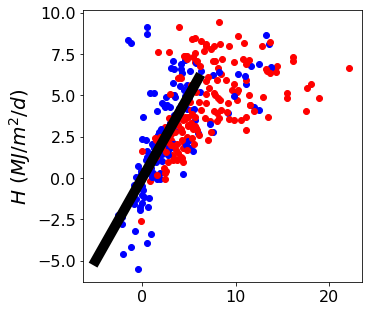

In [54]:
Comparison = plt.figure(figsize = (5,5))
Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(1,1,Position)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.05 
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/lamda'].groupby(level='Date',axis=0).mean().resample('d').sum()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'EstH'].groupby(level='Date',axis=0).mean().resample('d').sum()
        #Upp = yData + ySEM
        #Low = yData - ySEM
        #xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, 'o', color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        #plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    #plt.ylim(-17,25)
    LinePos +=1
    #fig.xaxis.set_major_locator(mdates.MonthLocator())
    #fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    #plt.xlim('2014-11-01','2015-02-15')
    #plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2
factor = 1
xs = [-5*factor,6*factor]
plt.plot(xs,np.divide(xs,factor),'-',linewidth=10,color='k')



In [55]:
Comparison = plt.figure(figsize = (18,10))
Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(1,2,Position)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.05 
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/lamda'].groupby(level='Date',axis=0).mean().resample('d').sum()
        ySEM = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/lamda'].groupby(level='Date',axis=0).std().resample('d').sum()
        Upp = yData + ySEM
        Low = yData - ySEM
        xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    #plt.ylim(-17,25)
    LinePos +=1
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.xlim('2014-11-01','2015-02-15')
    plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2

Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(1,2,2)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.05 
        denom = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/lamda'].groupby(level='Date',axis=0).mean().resample('d').sum()
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'EstH'].groupby(level='Date',axis=0).mean().resample('d').sum()/denom
        ySEM = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'EstH'].groupby(level='Date',axis=0).std().resample('d').sum()
        Upp = yData + ySEM
        Low = yData - ySEM
        xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.ylim(-10,100)
    LinePos +=1
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.xlim('2014-11-01','2015-02-15')
    plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2



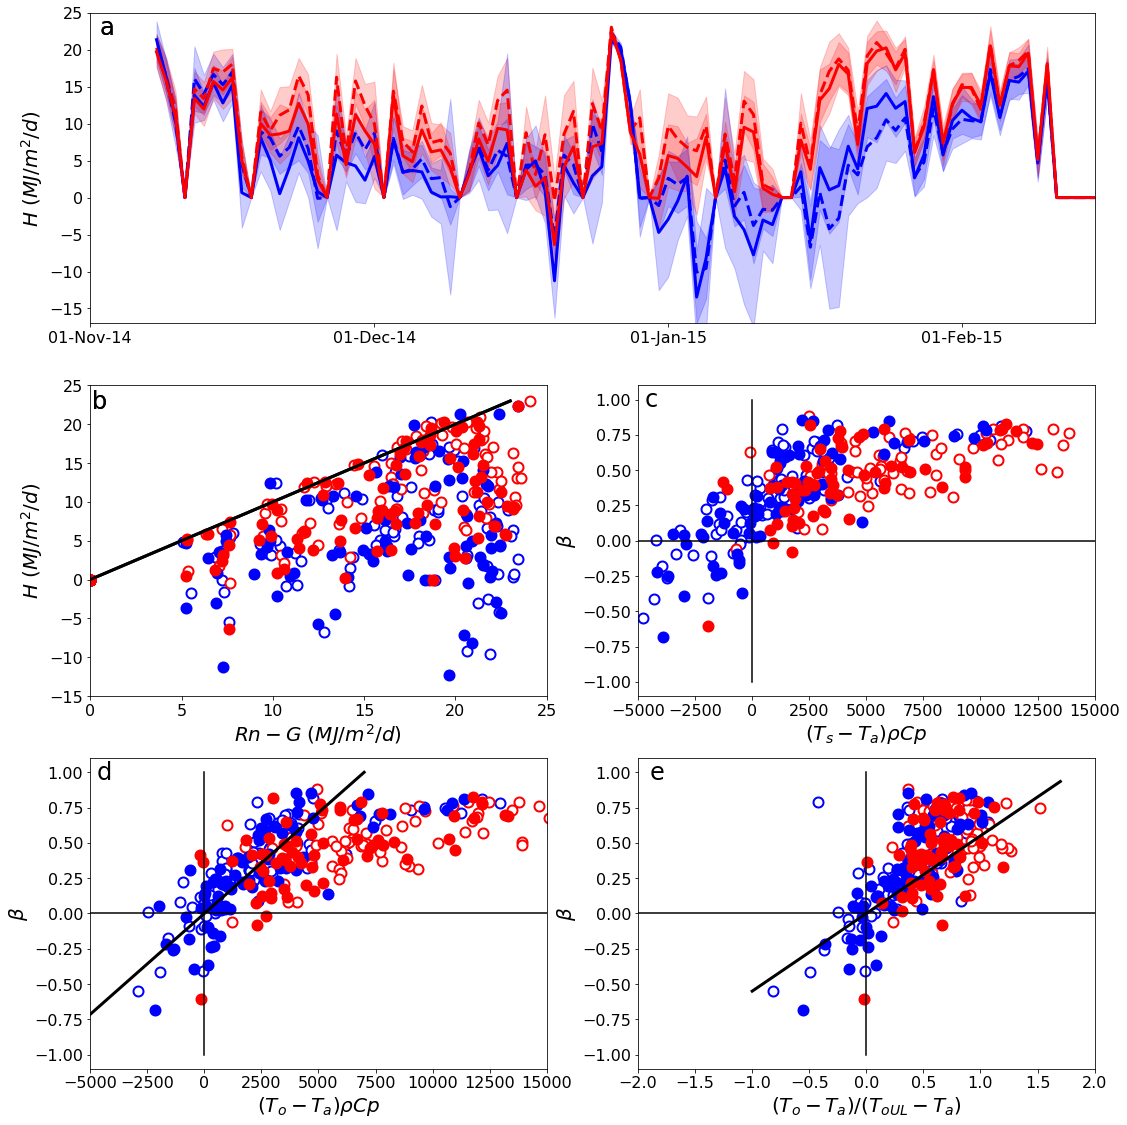

In [56]:
# A)
Comparison = plt.figure(figsize = (18,40))
Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(6,1,Position)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.05 
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        ySEM = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).std().resample('d').sum()
        Upp = yData + ySEM
        Low = yData - ySEM
        xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.ylim(-17,25)
    LinePos +=1
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.xlim('2014-11-01','2015-02-15')
    plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2

# B)
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .1)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'Rn-G'].groupby(level='Date',axis=0).mean().resample('d').sum()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.xlabel('$Rn-G$ $(MJ/m^2/d)$', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(-15,25)
    plt.xlim(0,25)
    plt.text(0.1,22, 'b', fontsize = 24)
    plt.plot([0,23],[0,23],'-',color='k',linewidth=3)
Position +=1

# C)
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0 
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'(Ts-Ta)qCp'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1,1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$\beta $', fontsize= 20)
plt.xlabel(r'$(T_s-T_a) \rho Cp$', fontsize= 20)
plt.tick_params(labelsize = 16)
plt.ylim(-1.1,1.1)
plt.xlim(-5000,15000)
plt.text(-4700, 0.95, 'c', fontsize = 24)
Position +=1

# D)
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'(To-Ta)qCp'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1,1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$\beta $', fontsize= 20)
plt.xlabel(r'$(T_o-T_a) \rho Cp$', fontsize= 20)
plt.tick_params(labelsize = 16)
plt.ylim(-1.1,1.1)
plt.xlim(-5000,15000)
plt.text(-4700, 0.95, 'd', fontsize = 24)
Position +=1
plt.plot([-7000,7000],[-1,1],'-',color='k',linewidth=3)


# E)
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0) & (EnergyBalance.loc[:,'(To-Ta)/(ToUL-Ta)']>-10)\
        &(EnergyBalance.loc[:,'(Ts-Ta)/(TsUL-Ta)']<2)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'(To-Ta)/(ToUL-Ta)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1,1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$\beta $', fontsize= 20)
plt.xlabel(r'$(T_o-T_a) / (T_{oUL}-T_a)$', fontsize= 20)
plt.tick_params(labelsize = 16)
plt.ylim(-1.1,1.1)
plt.xlim(-2,2)
plt.text(-1.9, 0.95, 'e', fontsize = 24)
Position +=1
plt.plot([-1.,1.7],[-0.55,0.935],'-',color='k',linewidth=3)

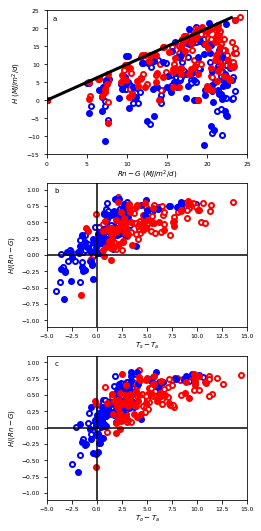

In [58]:
Comparison = plt.figure(figsize = (3.6,9))
# A)
fig = Comparison.add_subplot(3,1,1)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .1)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'Rn-G'].groupby(level='Date',axis=0).mean().resample('d').sum()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=5,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 7)
plt.xlabel('$Rn - G$ $(MJ/m^2/d)$', fontsize= 7)
plt.tick_params(labelsize = 6)
plt.ylim(-15,25)
plt.xlim(0,25)
plt.text(0.8,22, 'a', fontsize = 7)
plt.plot([0,23],[0,23],'-',color='k',linewidth=3)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6)
fig.xaxis.labelpad = 2

# B)
fig = Comparison.add_subplot(3,1,2)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0 
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'Ts-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=5,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1.1,1.1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$H/(Rn-G)$', fontsize= 7)
plt.xlabel(r'$T_s-T_a$', fontsize= 7)
plt.tick_params(labelsize = 6)
plt.ylim(-1.1,1.1)
plt.xlim(-5,15)
plt.text(-4.2, 0.95, 'b', fontsize = 7)
Position +=1
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6)
fig.xaxis.labelpad = 2

# c)
fig = Comparison.add_subplot(3,1,3)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'To-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=5,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1.1,1.1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$H/(Rn-G)$', fontsize= 7)
plt.xlabel(r'$T_o-T_a$', fontsize= 7)
plt.tick_params(labelsize = 6)
plt.ylim(-1.1,1.1)
plt.xlim(-5,15)
plt.text(-4.2, 0.95, 'c', fontsize = 7)
Position +=1
#plt.plot([-7000,7000],[-1,1],'-',color='k',linewidth=3)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6)
fig.xaxis.labelpad = 2

Comparison.savefig('Fig_6.jpg',dpi=1000)

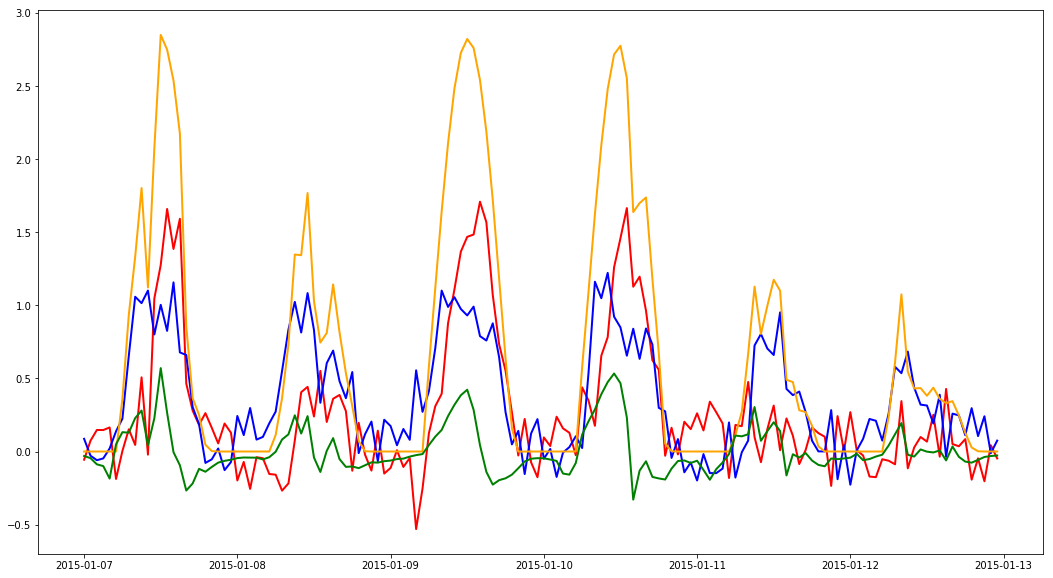

In [59]:
Graph = plt.figure(figsize=(18,10))
lines = ['--','--','-','-']
Widths = [1,2,1,2]
Pos = 3
for Cult in ['Dash']:#Cultivars:
    for Irr in ['Low']:#IrrigationsSub:
        HData = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'H'].loc['2015-01-07':'2015-01-12']
        LEData = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'LE'].loc['2015-01-07':'2015-01-12']
        RnData = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'Rn'].loc['2015-01-07':'2015-01-12']
        GData = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'G'].loc['2015-01-07':'2015-01-12']
        xData = HData.index
        plt.plot(xData,HData,lines[Pos],color='r',linewidth=Widths[Pos])
        plt.plot(xData,LEData,lines[Pos],color='b',linewidth=Widths[Pos])
        plt.plot(xData,RnData,lines[Pos],color='orange',linewidth=Widths[Pos])
        plt.plot(xData,GData,lines[Pos],color='g',linewidth=Widths[Pos])
        Pos+=1

In [60]:
Graph = plt.figure(figsize=(18,10))
lines = ['--','--','-','-']
Widths = [1,2,1,2]
Dates = ['2015-01-07','2015-01-30']
Pos = 3
for Cult in ['Dash']:#Cultivars:
    for Irr in ['High']:#IrrigationsSub:
        TsTa = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'Ts-Ta'].loc[Dates[0]:Dates[1]]
        ToTa = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'To-Ta'].loc[Dates[0]:Dates[1]]
        TsULTa = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'TsUL-Ta'].loc[Dates[0]:Dates[1]]
        ToULTa = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'ToUL-Ta'].loc[Dates[0]:Dates[1]]
        xData = TsTa.index
        plt.plot(xData,TsTa,'-',color='r',linewidth=Widths[Pos])
        plt.plot(xData,ToTa,'-',color='g',linewidth=Widths[Pos])
        plt.plot(xData,TsULTa,'--',color='r',linewidth=Widths[Pos])
        plt.plot(xData,ToULTa,'--',color='g',linewidth=Widths[Pos])
        Pos+=1

In [61]:
EnergyBalance.columns

Index(['Rn', 'G', 'PHWU', 'HLEMJ', 'Ta', 'u', 'q', 'VPD', 'lamda', 'LE', 'H',
       'Ts', 'uVPD', 'Ts-Ta', 'qCp', 'Cover', 'GreenCover', 'Rn-G', 'H/(Rn-G)',
       'abs(H/(Rn-G))', '(Ts-Ta)qCp', 'Ra', 'abs(H/(Rn-G))/Ra', 'TsUL-Ta',
       'maxH/(Rn-G)', 'depH/(Rn-G)', '(TsUL-Ta)qCp', 'TsUL', 'ToUL', 'ToUL-Ta',
       '(ToUL-Ta)qCp', 'To', 'To-Ta', '(To-Ta)qCp', '(Ts-Ta)/(TsUL-Ta)',
       '(To-Ta)/(ToUL-Ta)', '(To-Ta)aCp/(ToUL-Ta)qCp', 'ulim', 'EstH',
       'H/lamda'],
      dtype='object')

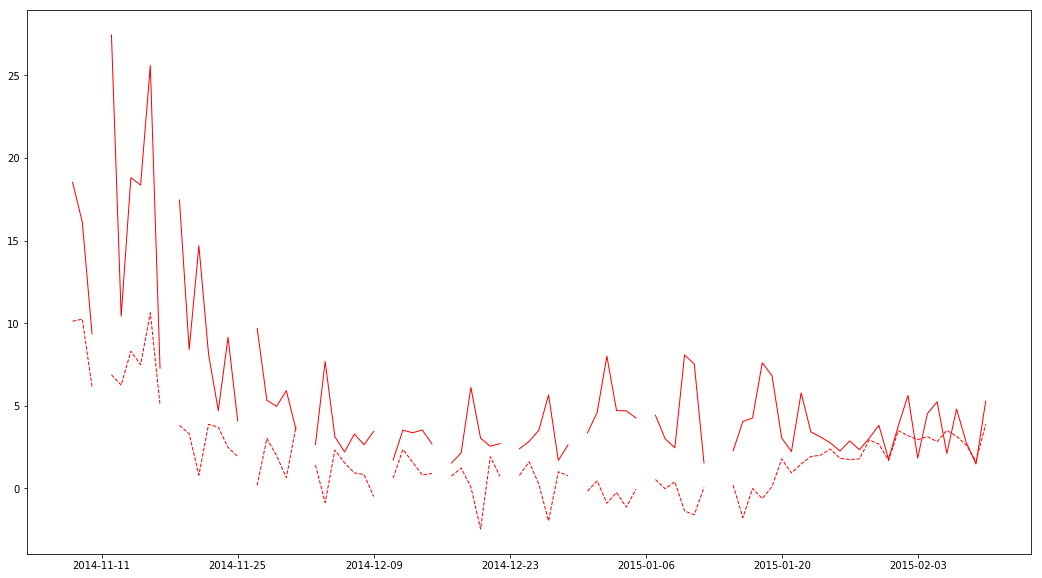

In [62]:
Graph = plt.figure(figsize=(18,10))
Colors = ['red','green','blue']
lines = ['--','--','-','-']
Widths = [1,2,1,2]
Dates = ['2015-01-07','2015-01-30']
Pos = 0
Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)
for Cult in ['Dash']:#Cultivars:
    for Irr in ['High']:
        ToTa = EnergyBalance.loc[Filter].groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'To-Ta'].resample('d').mean()
        ToULTa = EnergyBalance.loc[Filter].groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'ToUL-Ta'].resample('d').mean()
        xData = ToTa.index
        plt.plot(xData,ToTa,'--',color=Colors[Pos],linewidth=Widths[Pos])
        plt.plot(xData,ToULTa,'-',color=Colors[Pos],linewidth=Widths[Pos])
        Pos+=1


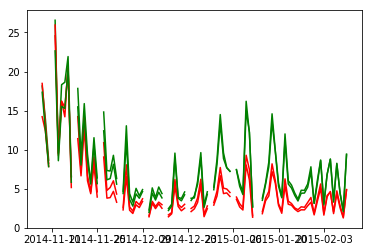

In [63]:
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.2)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'ToUL-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        #yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'To-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()/EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'ToUL-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = yData.index
        plt.plot(xData,yData,'-', color =  Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1


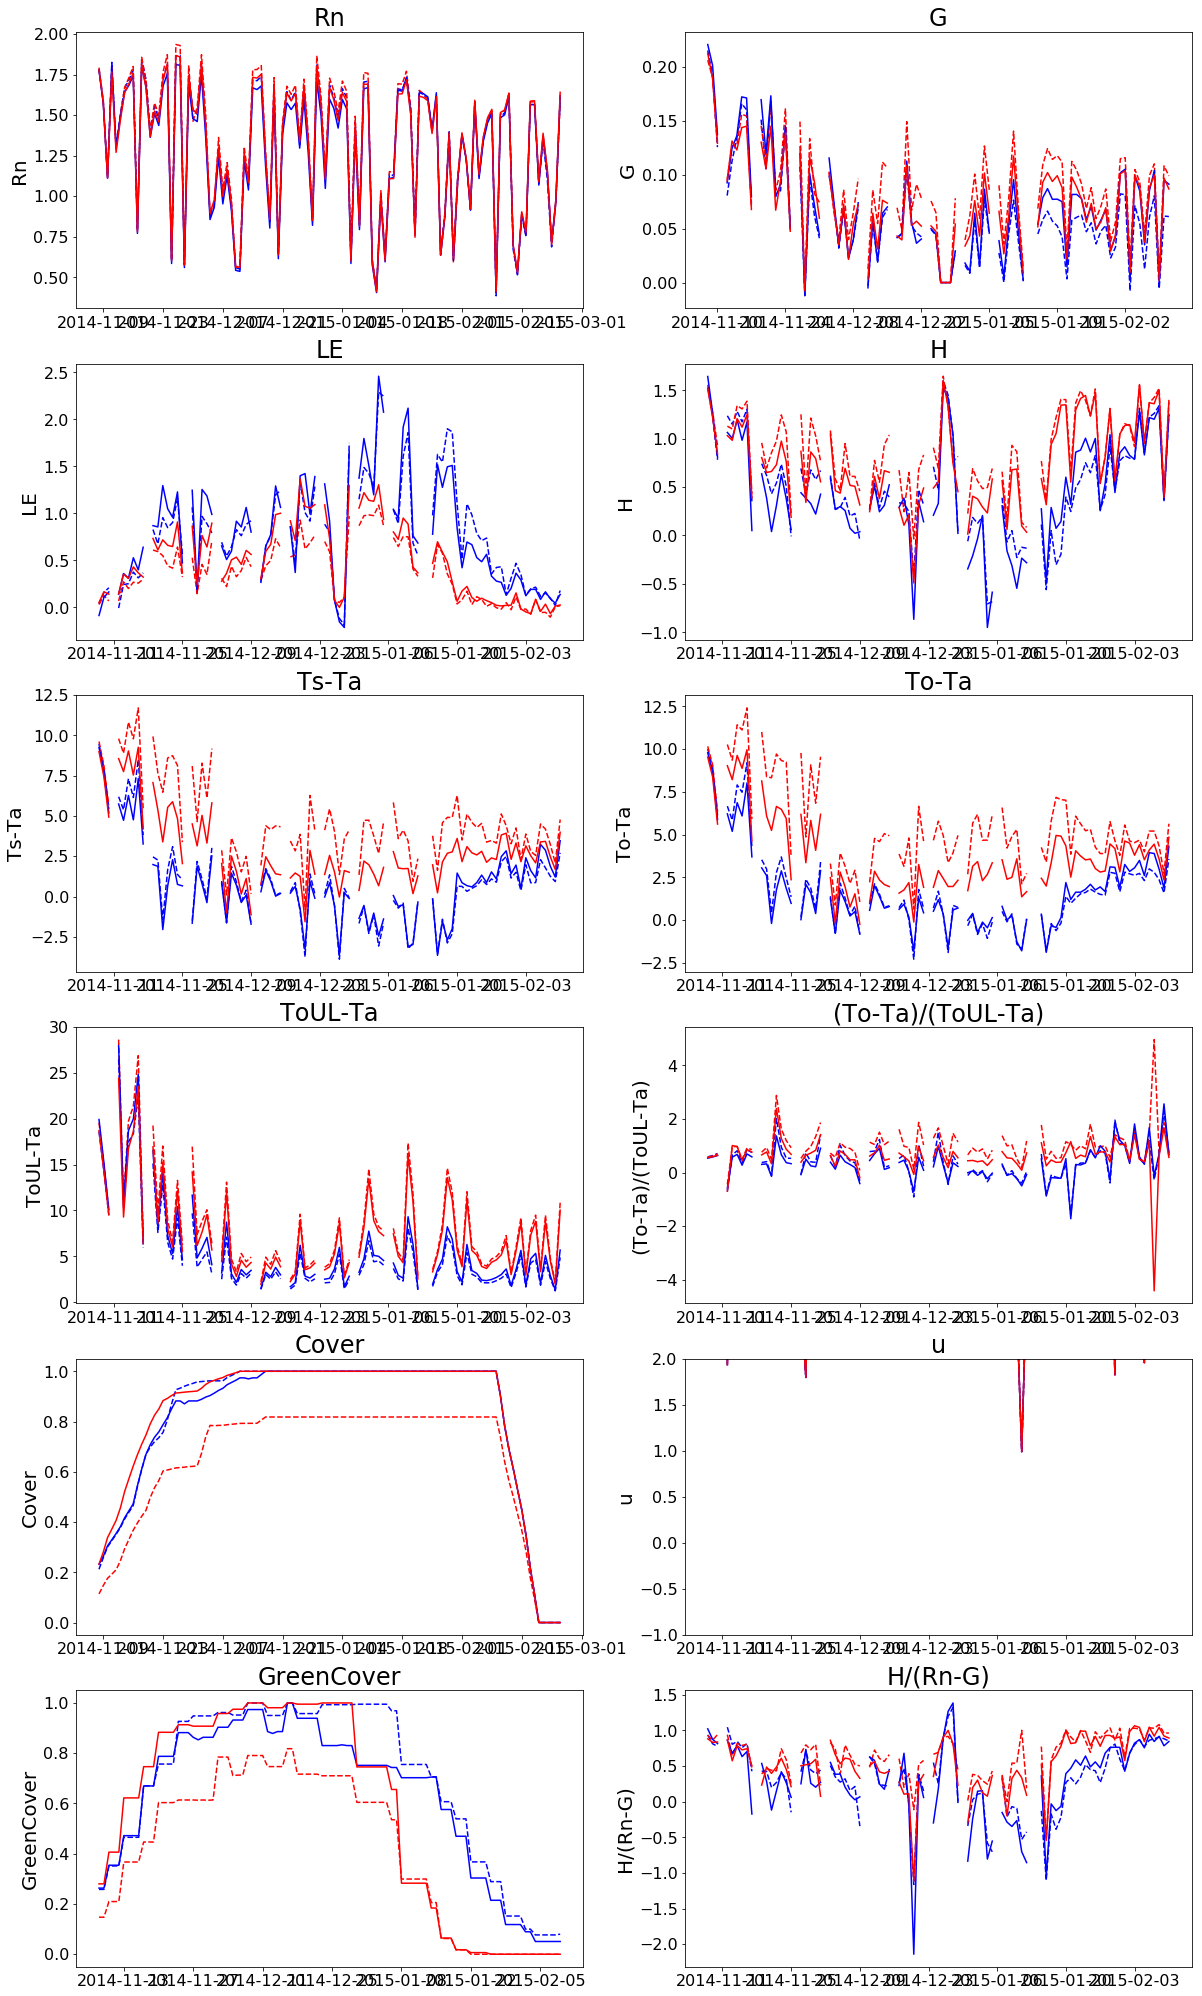

In [64]:
Comparison = plt.figure(figsize = (20,60))

Colors = ['blue','red','green']
Variables = ['Rn','G','LE','H','Ts-Ta','To-Ta','ToUL-Ta','(To-Ta)/(ToUL-Ta)','Cover','u','GreenCover','H/(Rn-G)']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(10,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in IrrigationsSub:
            Filter = EnergyBalance.Rn > 0.1 
            yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean().resample('d').mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    if Position == 10:
        plt.ylim(-1,2)
    plt.title(Var, fontsize = 24)
    Position +=1


(-1, 2)

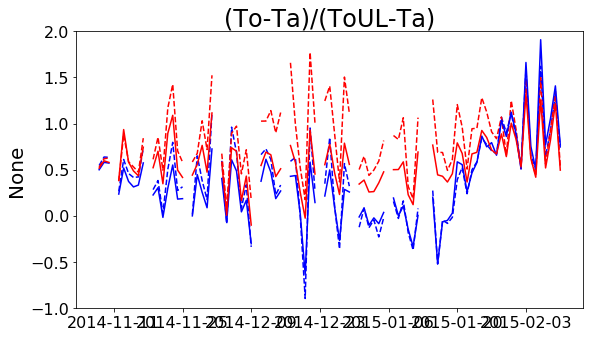

In [65]:
Comparison = plt.figure(figsize = (20,60))

Colors = ['blue','red','green']
Variables = ['(To-Ta)/(ToUL-Ta)']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(10,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in IrrigationsSub:
            Filter = EnergyBalance.Rn > 0 
            yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'To-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()/EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'ToUL-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    if Position == 10:
        plt.ylim(-1,2)
    plt.title(Var, fontsize = 24)
    Position +=1
plt.ylim(-1,2)

In [67]:
Comparison = plt.figure(figsize = (20,60))

Colors = ['blue','red','green']
Variables = ['To-Ta']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(10,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in IrrigationsSub:
            Filter = EnergyBalance.Rn > 0 
            yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean().resample('d').mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    if Position == 10:
        plt.ylim(-1,2)
    plt.title(Var, fontsize = 24)
    Position +=1
plt.ylim(-4,12)

(-4, 12)

(1, 15)

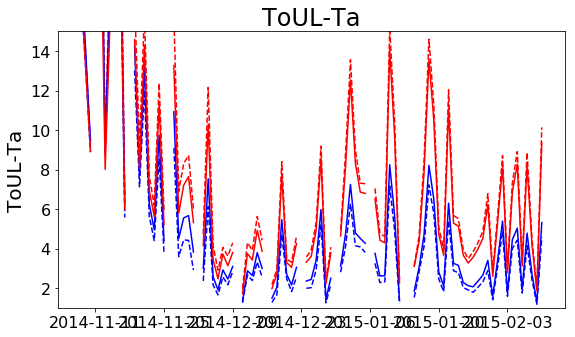

In [68]:
Comparison = plt.figure(figsize = (20,60))

Colors = ['blue','red','green']
Variables = ['ToUL-Ta']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(10,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in IrrigationsSub:
            Filter = EnergyBalance.Rn > 0 
            yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean().resample('d').mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    if Position == 10:
        plt.ylim(-1,2)
    plt.title(Var, fontsize = 24)
    Position +=1
plt.ylim(1,15)

KeyError: 'the label [ResH/(Rn-G)] is not in the [columns]'

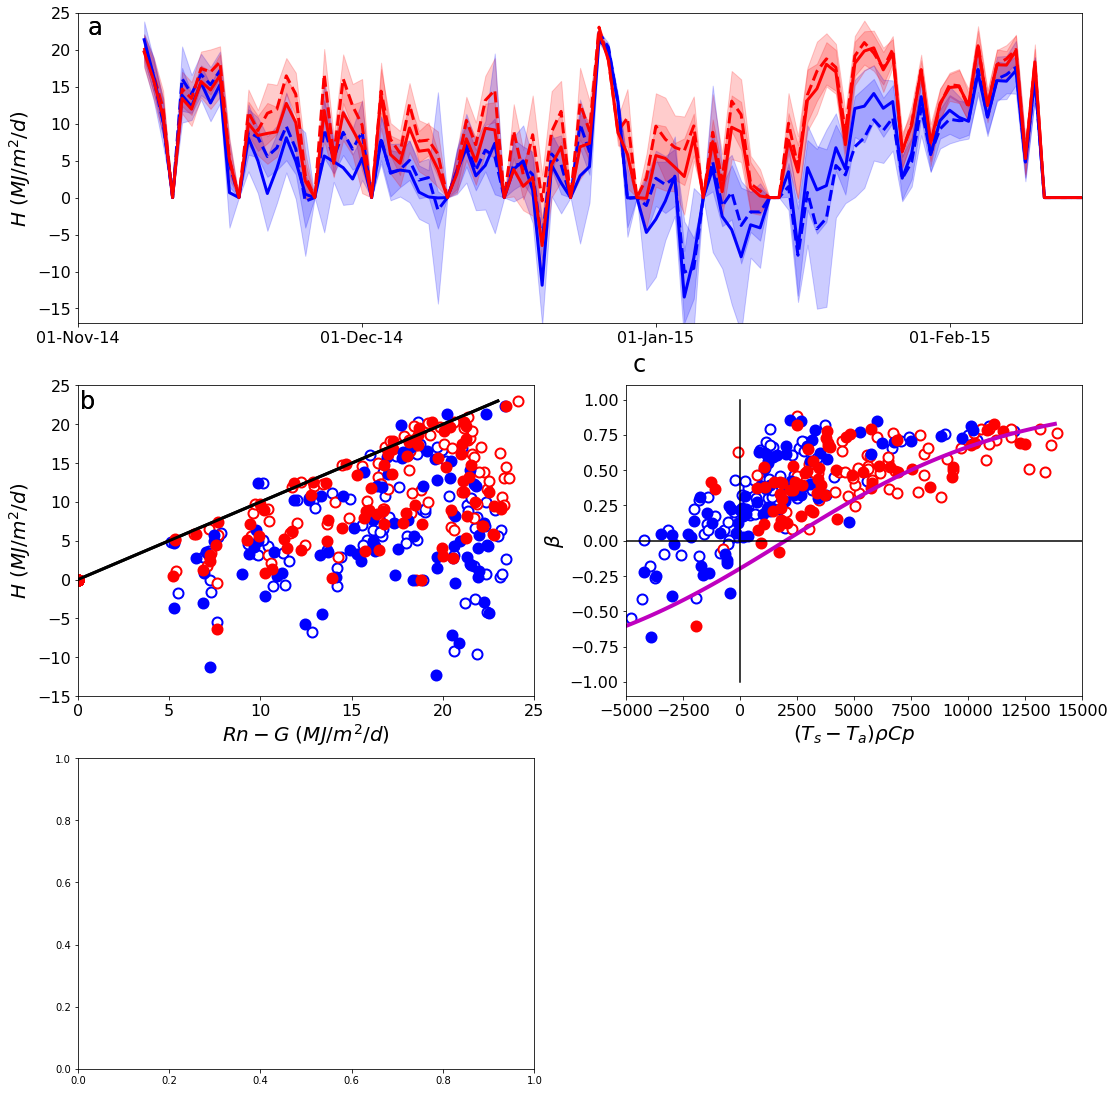

In [69]:
Comparison = plt.figure(figsize = (18,40))
Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(6,1,Position)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.01 
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        ySEM = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).std().resample('d').sum()
        Upp = yData + ySEM
        Low = yData - ySEM
        xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.ylim(-17,25)
    LinePos +=1
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.xlim('2014-11-01','2015-02-15')
    plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2

fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .1)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'Rn-G'].groupby(level='Date',axis=0).mean().resample('d').sum()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.xlabel('$Rn-G$ $(MJ/m^2/d)$', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(-15,25)
    plt.xlim(0,25)
    plt.text(0.1,22, 'b', fontsize = 24)
    plt.plot([0,23],[0,23],'-',color='k',linewidth=3)
Position +=1

fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0 
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'(Ts-Ta)qCp'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
# yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'EstH/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('h').mean()
# xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'(Ts-Ta)qCp'].groupby(level='Date',axis=0).mean().resample('h').mean()
# plt.plot(xData,yData,'o', mec = 'm', mfc = 'm', label = Irrigation,markersize=2,mew=2)
Xs = range(-6000,14000,200)
Ys1 = []
Ys0 = []
for x in Xs:
    y1 = 2/(1+np.exp((x+-2000)*-.0002)) - (2/2)
    y0 = C0/(1+np.exp((x+0)*-.001)) - (C0/2)
    Ys1.append(y1)
    Ys0.append(y0)
plt.plot(Xs,Ys1,'-',color='m',linewidth=4)
#plt.plot(Xs,Ys0,'-',color='c',linewidth=4)
plt.plot([0,0],[-1,1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$\beta $', fontsize= 20)
plt.xlabel(r'$(T_s-T_a) \rho Cp$', fontsize= 20)
plt.tick_params(labelsize = 16)
plt.ylim(-1.1,1.1)
plt.xlim(-5000,15000)
plt.text(-4700, 1.2, 'c', fontsize = 24)
Position +=1

fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .5)&(EnergyBalance.LE > .1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>6)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'ResH/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'u'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
    plt.ylabel(r'$res(\beta)$', fontsize= 20)
    plt.xlabel('$fPAR_{green}$', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(-2,2)
    #plt.xlim(0,1)
    #plt.plot([0,CB,1],[(C0-C1)/2,0,0],'-',color='k',linewidth=2)
    plt.plot([0,0.8,1],[.4,-0.1,-0.1],'-',color='k',linewidth=2)
    #yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'C'].groupby(level='Date',axis=0).mean().resample('d').mean()/2 - C1/2
    #xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'GreenCover'].groupby(level='Date',axis=0).mean().resample('d').mean()
    #plt.plot(xData,yData,'-', mec = 'm', mfc = 'm', label = Irrigation,markersize=2,mew=2)
    plt.text(0.02, 0.8, 'd', fontsize = 24)
Position +=1

fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .5)&(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)\
        &(EnergyBalance.loc[:,'Cover']>0.7)&(EnergyBalance.LE>0.1)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'ResH/(Rn-G)2'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'uVPD'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
    plt.ylabel(r'$res(\beta)$', fontsize= 20)
    plt.xlabel('$Wind$ $speed$ $(m/s)$', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(-1,1)
    plt.plot([0,4,8],[.5,0,0],'-',color='k',linewidth=2)
    #plt.text(0.2, 0.8, 'e', fontsize = 24)
Position +=1

In [ ]:
EnergyBalance.to_csv('.\DataFrames\EnergyBalanceData.csv')

## Look at sensible heat data in relation to canopy temp depression

In [ ]:
Descriptors = ['Ts-TaqCp','GreenCover']
Filter = (EnergyBalance.Rn > 0.6)#&(EnergyBalance.Ra <300)&(EnergyBalance.Ra>2)
X = EnergyBalance.loc[Filter,EnergyBalance.columns.isin(Descriptors)]
Y = EnergyBalance.loc[Filter,'H/(Rn-G)']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

In [ ]:
fig = plt.Figure()
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0 
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <0.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'Ts-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'VPD'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
#plt.plot([0,3],[1500,-7500])